# Transformer models

NLP tasks, with or without transformer models, look like the following pipeline:

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg)

We will detail each of the steps.

In [1]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## The imports

In [2]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [3]:
#!pip install transformers

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
model_name = "distilbert-base-uncased"
# Go to page https://huggingface.co/models for model list

## Transformer tokenization

Tokenizers are one of the core components of the NLP pipeline. They serve one purpose: to translate text into data that can be processed by the model. 

If we want to completely cover a language with a word-based tokenizer, we’ll need to have an identifier for each word in the language, which will generate a huge amount of tokens. For example, there are over 500,000 words in the English language, so to build a map from each word to an input ID we’d need to keep track of that many IDs. 

Finally, we need a custom token to represent words that are not in our vocabulary. This is known as the “unknown” token, often represented as ”[UNK]” or ””.

One way to reduce the amount of unknown tokens is to go one level deeper, using a character-based tokenizer. This approach isn’t perfect either. Since the representation is now based on characters rather than words, one could argue that, intuitively, it’s less meaningful: each character doesn’t mean a lot on its own, whereas that is the case with words. 

To get the best of both worlds (word an char tokenization), we can use a third technique that combines the two approaches: subword tokenization.

In [6]:
from transformers import AutoTokenizer

In [7]:
# Load a pre-trained small model.
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
sequence="don't be so judgmental"

In [9]:
sent = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(sent)
print("sent:\t\t", sent)
print("ids:\t\t", ids)
print("decode:\t\t", tokenizer.decode(ids))

sent:		 ['don', "'", 't', 'be', 'so', 'judgment', '##al']
ids:		 [2123, 1005, 1056, 2022, 2061, 8689, 2389]
decode:		 don't be so judgmental


In [10]:
model_inputs = tokenizer(sequence)
print("model_inputs:\t", model_inputs["input_ids"])
print("decode:\t\t", tokenizer.decode(model_inputs["input_ids"]))

model_inputs:	 [101, 2123, 1005, 1056, 2022, 2061, 8689, 2389, 102]
decode:		 [CLS] don't be so judgmental [SEP]


In [11]:
tokenizer(sequence, max_length=6, padding=True, truncation=True, return_tensors="np")

{'input_ids': array([[ 101, 2123, 1005, 1056, 2022,  102]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1]])}

## Transformer model

In [12]:
raw_inputs = [
    "I've been waiting for a Deep Learning course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="tf")
print(inputs)

Metal device set to: Apple M1 Max
{'input_ids': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2784, 4083, 2607,
        2026, 2878, 2166, 1012,  102],
       [ 101, 1045, 5223, 2023, 2061, 2172,  999,  102,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}


2022-10-20 10:18:58.848604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 10:18:58.849115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
from transformers import TFAutoModel

model = TFAutoModel.from_pretrained(model_name)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


The vector output by the Transformer module is usually large. It generally has three dimensions:

* Batch size: The number of sequences processed at a time (2 in our example).
* Sequence length: The length of the numerical representation of the sequence (16 in our example).
* Hidden size: The vector dimension of each model input.

In [15]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

(2, 16, 768)


Note that the outputs of Transformers models behave like namedtuples or dictionaries.

You can access the elements by attributes (like we did) or by key (outputs["last_hidden_state"]), or even by index if you know exactly where the thing you are looking for is (outputs[0]).

Shape explaination:
* 2 sentences
* Max_length = 16 (The longest sentence of the dataset or size fixed a priori)
* EMbedding_size = 768 (see model)

In [16]:
outputs["last_hidden_state"].shape

TensorShape([2, 16, 768])

In [17]:
outputs[0].shape

TensorShape([2, 16, 768])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


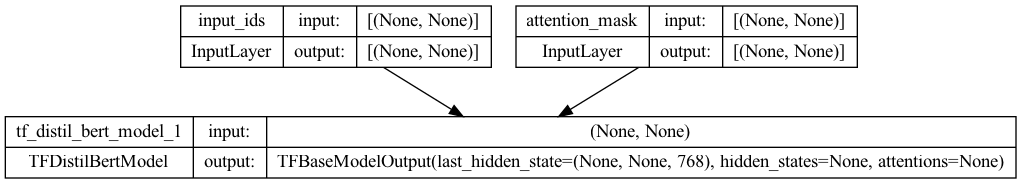

In [18]:
# We can plot the input and output of the model
""" with output_hidden_states = False
    return only hidden_state for last layer
"""
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
model = TFAutoModel.from_pretrained(model_name,
                                    return_dict=True,           # True return output dict. Use to select output
                                    output_hidden_states=False, # True return all hidden state
                                    output_attentions=False,    # True return all attention matrix
                                    )
outputs = model(input_ids=input_ids,
                  attention_mask = attention_mask)

bert_model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=outputs)

plot_model(bert_model, show_shapes=True, show_layer_names=True)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


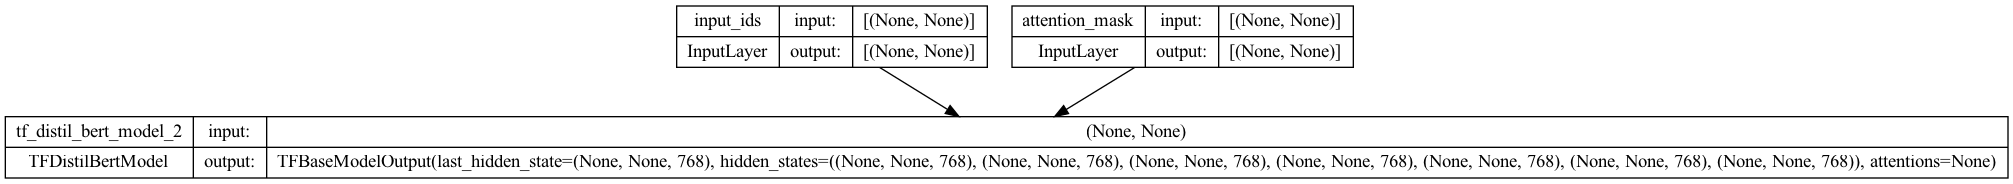

In [19]:
# We can plot the input and output of the model
""" with output_hidden_states = True
    return hidden_state for all layers
"""
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
model = TFAutoModel.from_pretrained(model_name,
                                    return_dict=True,           # True return output dict. Use to select output
                                    output_hidden_states=True,  # True return all hidden state
                                    output_attentions=False,    # True return all attention matrix
                                    )
outputs = model(input_ids=input_ids,
                  attention_mask = attention_mask)

bert_model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=outputs)

plot_model(bert_model, show_shapes=True, show_layer_names=True)

<font color="red">
Play with the output_hidden_states and output_attentions parameters to observe changes in the output tensor.
</font>

## Let's try to understand in depth


The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers:

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/transformer_and_head.svg)

The output of the Transformer model is sent directly to the model head to be processed.

In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

There are many different architectures available in Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

* Model (retrieve the hidden states)
* ForSequenceClassification (sentiment analysis)
* ForTokenClassification (POS, NER, ...)
* Translation task
* and others

<font color="blue">
As we are able to encapsulate all or part of a transform (here only the embedding part) in a Keras model, it is clear that it is possible to add various layers either before or after.
</font>

<hr>
<hr>

### Sequence classification task : N inputs tokens, 1 output labels


<font color="blue">
    <big><em>With a pre-trained pipeline</em></big>
</font>

In [20]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier("I've been waiting for a HuggingFace course my whole life.")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

[{'label': 'POSITIVE', 'score': 0.9598048329353333}]

<font color="blue">
    <big><em>Try to understand a little bit more</em></big>
</font>

In [21]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_96', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


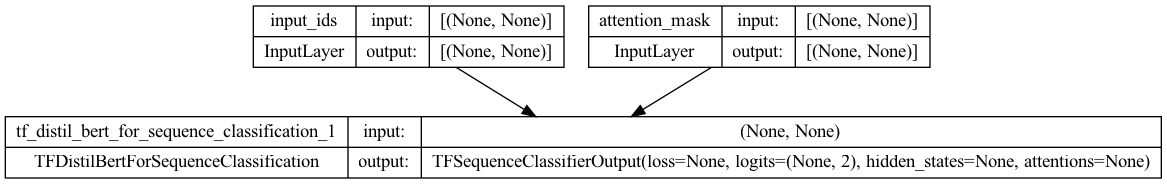

In [22]:
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
outputs_ = model(input_ids=input_ids,
                  attention_mask = attention_mask)

bert_model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=outputs_)

plot_model(bert_model, show_shapes=True, show_layer_names=True)

In [23]:
sentences = [
    "I've been waiting for a Deep Text course my whole life.",
    "This course is amazing!",
]

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="tf")
inputs

{'input_ids': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2784, 3793, 2607,
        2026, 2878, 2166, 1012,  102],
       [ 101, 2023, 2607, 2003, 6429,  999,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [24]:
outputs = model(inputs)
outputs.logits

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.06425199, -0.08580308],
       [-0.03809012, -0.0859838 ]], dtype=float32)>

To be converted to probabilities, they need to go through a SoftMax layer 

In [25]:
predictions = tf.math.softmax(outputs.logits, axis=-1)
print(predictions)

tf.Tensor(
[[0.5053876  0.4946125 ]
 [0.5119712  0.48802885]], shape=(2, 2), dtype=float32)


To get the labels corresponding to each position, we can inspect the id2label attribute of the model config:

In [26]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [27]:
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0])

<font color="blue">
    <big><em>Fine tune a pre-trained model for sentence classification task</em></big>
    
    The main objective here is to adapt post_processing to our task:
    * sentence classification
    * number of labels
</font>

In [28]:
corpus = ["I like chocolate",
            "I like tea",
            "You like chocolate",
            'You hate beer',
            'I hate milk, wine and beer']

labels = np.array([1,1,1,0,2]).reshape(-1, 1)

In [32]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Same as before
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(labels)))

batch = dict(tokenizer(corpus, padding=True, truncation=True, return_tensors="tf"))

# This is new
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.fit(batch, labels, epochs=5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_156']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/5


2022-10-20 10:34:39.401820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step - loss: 8.0918
Epoch 2/5
1/1 [==============================] - 0s 195ms/step - loss: 0.8789
Epoch 3/5
1/1 [==============================] - 0s 120ms/step - loss: 3.2155
Epoch 4/5
1/1 [==============================] - 0s 137ms/step - loss: 1.0986
Epoch 5/5
1/1 [==============================] - 0s 110ms/step - loss: 1.0986


In [33]:
new_sentence=["I like beer"]
new_input = tokenizer(new_sentence, padding=True, truncation=True, return_tensors="tf")
new_outputs = model(new_input)
new_outputs.logits.shape, np.argmax(new_outputs.logits, axis=1)

(TensorShape([1, 3]), array([2]))

<hr>
<hr>

### Token classification task : N inputs tokens, N output labels

<font color="blue">
    <big><em>With a pre-trained pipeline</em></big>
</font>


In [34]:
from transformers import pipeline

ner = pipeline("ner", grouped_entities=True)
ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing TFBertForTokenClassification: ['dropout_147']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized 

[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.97960204,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

<font color="blue">
    <big><em>Try to understand a little bit more</em></big>
</font>

In [35]:
from transformers import TFAutoModelForTokenClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForTokenClassification.from_pretrained("distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_250', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


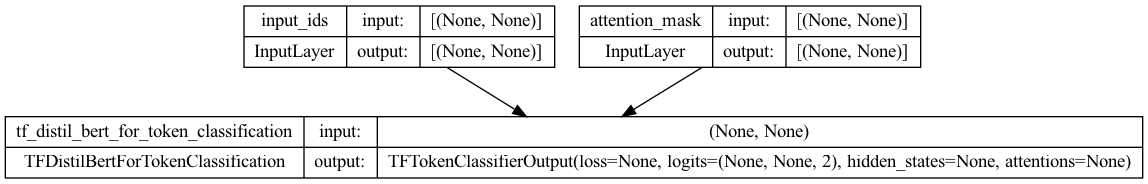

In [36]:
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
outputs_ = model(input_ids=input_ids,
                  attention_mask = attention_mask)

bert_model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=outputs_)

plot_model(bert_model, show_shapes=True, show_layer_names=True)

In [37]:
sentences = [
    "I've been waiting for a Deep Text course my whole life.",
    "This course is amazing!",
]

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="tf")
inputs

{'input_ids': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2784, 3793, 2607,
        2026, 2878, 2166, 1012,  102],
       [ 101, 2023, 2607, 2003, 6429,  999,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [38]:
outputs = model(inputs)
outputs.logits.shape

TensorShape([2, 16, 2])

In [39]:
predictions = tf.math.softmax(outputs.logits, axis=-1)
predictions = np.argmax(predictions, axis=-1)
predictions

array([[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

<font color="blue">
    <big><em>Fine tune a pre-trained model for token classification task</em></big>
    
    The main objective here is to adapt post_processing to our task:
    * token classification
    * number of labels
</font>

<font color="blue">
    <big>Understand the needed preprocessing</big>
</font>

In [40]:
#!pip install datasets

In [41]:
""" Load a dataset for NER task """
from datasets import load_dataset

raw_datasets = load_dataset("conll2003")

Found cached dataset conll2003 (/Users/miriveill/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
""" select one sentences """
X = raw_datasets["train"][8]["tokens"]
y = raw_datasets["train"][8]["ner_tags"]


""" select some sentences """
nb = 500
small_train_dataset = raw_datasets["train"].shuffle(seed=42).select(range(nb))

Loading cached shuffled indices for dataset at /Users/miriveill/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-2fe5320fac60946d.arrow


In [44]:
ner_feature = raw_datasets["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [45]:
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [46]:
label2id = {label:i for i, label in enumerate(label_names)}
label2id["SEP/CLS"] = -100

id2label = {v: k for k, v in label2id.items()}

nb_labels = len(label_names)

In [47]:
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8,
 'SEP/CLS': -100}

In [48]:
line1 = ""
line2 = ""
for word, label in zip(X, y):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1[:100])
print(line2[:100])

Fischler proposed EU-wide measures after reports from Britain and France that under laboratory condi
B-PER    O        B-MISC  O        O     O       O    B-LOC   O   B-LOC  O    O     O          O    


In [49]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [50]:
inputs = tokenizer(X, is_split_into_words=True)
print(inputs.tokens())

['[CLS]', 'fis', '##ch', '##ler', 'proposed', 'eu', '-', 'wide', 'measures', 'after', 'reports', 'from', 'britain', 'and', 'france', 'that', 'under', 'laboratory', 'conditions', 'sheep', 'could', 'contract', 'bo', '##vine', 'sp', '##ong', '##iform', 'en', '##ce', '##pha', '##lo', '##pathy', '(', 'bs', '##e', ')', '-', '-', 'mad', 'cow', 'disease', '.', '[SEP]']


<font color="red">
As we can see, the tokenizer added the special tokens used by the model ([CLS] at the beginning and [SEP] at the end) and left most of the words untouched. Some words, however, was tokenized into three subwords, 'fis', '##ch', '##ler'.

This introduces a mismatch between our inputs and the labels.

Fortunately, for many tokenizers, we can easily match each token to its label.
</font>

In [51]:
print(inputs.word_ids())

[None, 0, 0, 0, 1, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 18, 18, 18, 19, 19, 19, 19, 19, 20, 21, 21, 22, 23, 23, 24, 25, 26, 27, None]


In [52]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id is None:
            # Special token
            current_word = word_id
            new_labels.append(label2id["SEP/CLS"]) #--> Add the same extra label for CLS/SEP
        elif word_id != current_word:
            # Start of a new word!
            current_word = word_id
            new_labels.append(labels[word_id])
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [53]:
print(y)
print(align_labels_with_tokens(y, inputs.word_ids()))

[1, 0, 7, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 0, 7, 0, 0, 0, 0, 0, 0]
[-100, 1, 2, 2, 0, 7, 8, 8, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, -100]


In [54]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

Note that we haven’t padded our inputs yet; we’ll do that later, when creating the batches with a data collator.

In [55]:
tokenized_train_datasets = small_train_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=small_train_dataset.column_names,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

<font color="blue">
    <big>Fine-tuning your own model</big>
<font color="red">
<br>
    
The main difficulty is to put the data set expected by the model. Here is a proposal from the tutorial available on the website "huggingface.co".
</font>
    
* [Access to the tutorial](https://huggingface.co/course/chapter7/2?fw=tf)
    
If your work with your own dataset use the [load_dataset](https://huggingface.co/docs/datasets/loading) function provided by huggingface

**Prepare the dataset**

In [57]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    return_tensors="tf"
)

In [58]:
batch = data_collator([tokenized_train_datasets[i] for i in range(2)])
batch["labels"]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<tf.Tensor: shape=(2, 38), dtype=int64, numpy=
array([[-100,    0,    0,    0,    7,    8,    0,    7,    0,    0,    0,
           0,    0,    0,    0,    0,    7,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    5,
           0,    5,    0,    0, -100],
       [-100,    5,    0,    0,    0,    0,    0, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100]])>

In [59]:
for i in range(2):
    print(tokenized_train_datasets[i]["labels"])

[-100, 0, 0, 0, 7, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, -100]
[-100, 5, 0, 0, 0, 0, 0, -100]


In [60]:
tf_train_dataset = tokenized_train_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"], #, "token_type_ids"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1,
)

**Build and fit the model**

In [61]:
from transformers import AutoTokenizer, TFAutoModelForTokenClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForTokenClassification.from_pretrained("distilbert-base-uncased",
                                                          id2label=id2label,
                                                          label2id=label2id,
)
model.config.num_labels

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_270']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

10

There is no need to provide a loss function to the compile() function. This is because templates can calculate the loss internally that is appropriate for the task and template type you have chosen.

In [62]:
from transformers import create_optimizer

epochs = 2

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=len(tf_train_dataset) * epochs,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer)
model.fit(tf_train_dataset, epochs=epochs, verbose=1)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/2


2022-10-20 10:44:38.915512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 1000s 2s/step - loss: 0.5039
Epoch 2/2
500/500 [==============================] - 979s 2s/step - loss: 0.1552


**Evaluate the model**

In [64]:
#!pip install seqeval`

In [65]:
from seqeval.metrics import classification_report

In [66]:
# Preprocess the test dataset
small_test_dataset = raw_datasets["train"].shuffle(seed=42).select(range(5))
tokenized_test_datasets = small_test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=small_test_dataset.column_names,
)
tf_test_dataset = tokenized_test_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"], #"token_type_ids"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1,
)

Loading cached shuffled indices for dataset at /Users/miriveill/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-2fe5320fac60946d.arrow
Loading cached processed dataset at /Users/miriveill/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-33f743642a974d65.arrow


In [67]:
import numpy as np

all_pred = []
all_true = []
for batch in tf_test_dataset:
    logits = model.predict(batch)["logits"]
    labels = batch["labels"]
    predictions = np.argmax(logits, axis=-1)
    for prediction, label in zip(predictions, labels):
        print(prediction)
        p_ = []
        t_ = []
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == label2id["SEP/CLS"]:
                continue
            p_.append(label_names[predicted_idx])
            t_.append(label_names[label_idx])
        all_pred.append(p_)
        all_true.append(t_)

2022-10-20 11:21:52.342136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step
[0 0 0 0 7 4 0 7 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 5 0 0
 6]


2022-10-20 11:21:57.727262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step
[0 5 0 0 0 0 0 6]
1/1 [==============================] - 3s 3s/step
[0 3 4 4 0 0 0 0 0 0 0 6]
1/1 [==============================] - 3s 3s/step
[0 0 0 0 0 0 0 0 7 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6]
1/1 [==============================] - 1s 547ms/step
[0 5 0 0 0 0 0 6]


In [68]:
print(classification_report(all_pred, all_true))

              precision    recall  f1-score   support

         LOC       1.00      1.00      1.00         5
        MISC       0.75      0.75      0.75         4
         ORG       1.00      0.50      0.67         2

   micro avg       0.90      0.82      0.86        11
   macro avg       0.92      0.75      0.81        11
weighted avg       0.91      0.82      0.85        11



<hr>
<hr>

### Translation task : N inputs tokens, M output labels

Similar task:
* Translation: Creating a model that translates texts written in a certain style to another (e.g., formal to casual or Shakespearean English to modern English), or translate sentences from one language to another one ;
* Q&A : Creating a model that generates answers to questions, given a context ;
* Text summarization: understanding long passages and generating coherent text that captures the main topics in a document.

<font color="blue">
    <big><em>With a pre-trained pipeline</em></big>
</font>

In [70]:
from transformers import pipeline

translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")
translator("Ce cours est produit par Hugging Face.")

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/301M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-fr-en.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

[{'translation_text': 'This course is produced by Hugging Face.'}]

<font color="blue">
    <big><em>Try to understand a little bit more</em></big>
</font>

In [71]:
from datasets import load_dataset

raw_datasets = load_dataset("kde4", lang1="en", lang2="fr")

Using custom data configuration en-fr-lang1=en,lang2=fr
Found cached dataset kde4 (/Users/miriveill/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac)


  0%|          | 0/1 [00:00<?, ?it/s]

In [72]:
# Select only some sentences
nb = 18

split_datasets = raw_datasets["train"].select(range(nb)).train_test_split(train_size=0.9, seed=20)
split_datasets

Loading cached split indices for dataset at /Users/miriveill/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac/cache-e77c3a039db6a83f.arrow and /Users/miriveill/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac/cache-c55a7419ebb6ab45.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 16
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 2
    })
})

In [73]:
# take a look at one element of the dataset:
split_datasets["train"][0]["translation"]

{'en': 'Not all languages are available from the Babelfish service.',
 'fr': 'Toutes les langues ne sont pas disponibles à partir du service Babelfish.'}

In [74]:
#!pip install sentencepiece

In [75]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
# The Helsinki-NLP/opus-mt-en-fr checkpoint only has PyTorch weights -- return_tensors="pt"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")


Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

If you are using a multilingual tokenizer such as mBART, mBART-50, or M2M100, you will need to set the language codes of your inputs and targets in the tokenizer by setting tokenizer.src_lang and tokenizer.tgt_lang to the right values.

The preparation of our data is pretty straightforward. There’s just one thing to remember; you need to ensure that the tokenizer processes the targets in the output language (here, French). You can do this by passing the targets to the `text_targets` argument of the tokenizer’s `__call__` method.

In [76]:
en_sentence = split_datasets["train"][0]["translation"]["en"]
fr_sentence = split_datasets["train"][0]["translation"]["fr"]

inputs = tokenizer(en_sentence, text_target=fr_sentence)
inputs # Input_ids: token in a source language / labels: tokens in a target language

{'input_ids': [2033, 98, 3467, 52, 494, 64, 4, 188, 25028, 14473, 272, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [3743, 16, 2594, 76, 70, 53, 1559, 17, 929, 22, 272, 188, 25028, 483, 3089, 3, 0]}

In [77]:
# token to text for input language
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))

['▁Not', '▁all', '▁languages', '▁are', '▁available', '▁from', '▁the', '▁B', 'abel', 'fish', '▁service', '.', '</s>']


In [78]:
# token to text for output language (labels)
print(tokenizer.convert_ids_to_tokens(inputs["labels"]))

['▁Toutes', '▁les', '▁langues', '▁ne', '▁sont', '▁pas', '▁disponibles', '▁à', '▁partir', '▁du', '▁service', '▁B', 'abel', 'f', 'ish', '.', '</s>']


In [79]:
# If we use the wrong tokenizer, here English for French text.
wrong_targets = tokenizer(fr_sentence) # 
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"]))

['▁To', 'ute', 's', '▁les', '▁langue', 's', '▁ne', '▁son', 't', '▁pa', 's', '▁dis', 'pon', 'ible', 's', '▁à', '▁part', 'ir', '▁du', '▁service', '▁B', 'abel', 'fish', '.', '</s>']


As we can see, using the English tokenizer to preprocess a French sentence results in a lot more tokens, since the tokenizer doesn’t know any French words (except those that also appear in the English language, like “discussion”).

In [80]:
max_length = 128

def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["fr"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

We can now apply that preprocessing in one go on all the splits of our dataset:

In [81]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

Loading cached processed dataset at /Users/miriveill/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac/cache-5a35de402b8df58b.arrow
Loading cached processed dataset at /Users/miriveill/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac/cache-47079d5a28bbed26.arrow


In [82]:
model_checkpoint

'Helsinki-NLP/opus-mt-en-fr'

In [84]:
#!pip install torch

In [85]:
#!pip install torch
from transformers import TFAutoModelForSeq2SeqLM

# The Helsinki-NLP/opus-mt-en-fr checkpoint only has PyTorch weights -- return_tensors="pt"
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, from_pt=True)

All PyTorch model weights were used when initializing TFMarianMTModel.

All the weights of TFMarianMTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


We’ll need a data collator to deal with the padding for dynamic batching. We can’t just use a DataCollatorWithPadding like in the previous example (NER task), because that only pads the inputs (input IDs, attention mask, and token type IDs). Our labels should also be padded to the maximum length encountered in the labels. And, as mentioned previously, the padding value used to pad the labels should be -100 and not the padding token of the tokenizer, to make sure those padded values are ignored in the loss computation.

In [86]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer,
                                       model=model,
                                       return_tensors="tf")

In [87]:
# use this data_collator to convert each of our datasets to a tf.data.Dataset
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)
tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

**Fine tune the model**

In [88]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [89]:
from transformers import create_optimizer
import tensorflow as tf

# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Fit the model
model.fit(
    tf_train_dataset,
    epochs=num_epochs,
)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Epoch 1/3


2022-10-20 12:19:40.490142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 50s 50s/step - loss: 0.9289
Epoch 2/3
1/1 [==============================] - 3s 3s/step - loss: 0.6057
Epoch 3/3
1/1 [==============================] - 4s 4s/step - loss: 0.4805


**Using the fine-tuned model**

In [90]:
y_pred = model.predict(tf_test_dataset)['logits']
y_pred = np.argmax(y_pred, axis=-1)
y_pred.shape

2022-10-20 12:20:32.402664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 13s 13s/step


(2, 55)

In [91]:
y_true = np.zeros_like(y_pred_fine_tuned)
for elt in tf_test_dataset.as_numpy_iterator():
    y_true = elt['labels']
mask = (y_true>0)

In [92]:

for y_, t_, mask in zip(y_pred, y_true, mask):
    print("-"*50)
    print(''.join(tokenizer.convert_ids_to_tokens(t_[mask])))
    print(''.join(tokenizer.convert_ids_to_tokens(y_[mask])))

--------------------------------------------------
▁&▁traducteurJeromeBlanc;
▁R▁R_▁suis_</s>
--------------------------------------------------
▁Vous▁pouvez▁accéder▁au▁module▁externe▁Babelfish▁depuis▁la▁barre▁de▁menus▁de▁&▁konqueror;,▁dans▁Outils▁Traduire▁la▁page▁web.▁Choisissez▁dans▁la▁liste▁déroulante▁la▁langue▁du▁texte▁à▁traduire▁et▁la▁langue▁dans▁laquelle▁vous▁souhaitez▁la▁traduire.
▁Le▁pouvez▁accéder▁au▁module▁externe▁Babelfish▁dans▁la▁barre▁de▁menus▁de▁&▁konqueror;▁sous▁sous▁la▁Transduire▁la▁page▁Web.▁Sélectionnez▁dans▁la▁liste▁quie▁la▁langue▁à▁texte▁et▁traduire▁et▁la▁langue▁à▁laquelle▁il▁devez▁traduire▁traduire.


## Text generation

<font color="blue">
    <big><em>With a pre-trained pipeline</em></big>
</font>

In [95]:
from transformers import pipeline

generator = pipeline("text-generation", model="distilgpt2")
generator(
    "Michel RIVEILL is",
    max_length=30,
    num_return_sequences=2,
)

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


[{'generated_text': 'Michel RIVEILL is a professor of psychology at Yale University. She writes about the psychology of the public.'},
 {'generated_text': 'Michel RIVEILL is a PhD student based on research on health and well-being at the University of California Riverside. He is an author,'}]

## Other task with transformer

https://huggingface.co/docs/transformers/task_summary